In [2]:
from dataset import CarbonDataset
from models.segformer_simple import Segformerwithcarbon , Segwithcarbon
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from models.util import select_device
from models.metrics import CarbonLoss

device = select_device()

fp_forest = 'Dataset/Training/image/AP25_Forest_IMAGE'
fp_city = 'Dataset/Training/image/AP25_City_IMAGE'
args = {
#C
'dims':             (64, 128, 320, 512),
'decoder_dim': 512,
#R
'reduction_ratio': (8, 4, 2, 1),
#N
'heads':           (1, 2, 5, 8),
#E
'ff_expansion':     (8, 8, 4, 4),
#L
'num_layers':       (3, 3, 8, 3),
'channels': 4,#input channels
'num_classes': 4,
'stage_kernel_stride_pad': [(4, 2, 1), 
                                (3, 2, 1), 
                                (3, 2, 1), 
                                (3, 2, 1)],

}
model = Segwithcarbon(**args)
pretrain_loc = 'checkpoints\Segwithcarbon\Domain_Apdaptation\DA_B3_SegwithcarbonAP25_Forest_128_best.pth'
model.load_state_dict(torch.load(pretrain_loc))
model.to(device)
loss = CarbonLoss(num_classes=4,cls_lambda=1,reg_lambda=0.0005).to(device)
# 데이터셋을 위한 변환 정의
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
sh_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

label_transform = transforms.Compose([
    transforms.Resize((128, 128)), 
])
resizer = transforms.Compose([
    transforms.Resize((128, 128))
])


# 데이터셋 및 데이터 로더 생성
forest_train_dataset = CarbonDataset(fp_forest, image_transform, sh_transform, label_transform,mode="Train")
forest_train_loader = DataLoader(forest_train_dataset, batch_size=1, shuffle=True,pin_memory=True)

forest_val_dataset = CarbonDataset(fp_forest, image_transform,sh_transform, label_transform,mode="Valid")
forest_val_loader = DataLoader(forest_val_dataset, batch_size=1, shuffle=False,pin_memory=True)

city_train_dataset = CarbonDataset(fp_city, image_transform, sh_transform, label_transform,mode="Train")
city_train_loader = DataLoader(city_train_dataset, batch_size=1, shuffle=True,pin_memory=True)

city_val_dataset = CarbonDataset(fp_city, image_transform,sh_transform, label_transform,mode="Valid")
city_val_loader = DataLoader(city_val_dataset, batch_size=1, shuffle=False,pin_memory=True)



RuntimeError: Error(s) in loading state_dict for Segformerwithcarbon:
	Missing key(s) in state_dict: "mit.stages.2.2.6.0.fn.to_q.weight", "mit.stages.2.2.6.0.fn.to_kv.weight", "mit.stages.2.2.6.0.fn.to_out.weight", "mit.stages.2.2.6.0.norm.g", "mit.stages.2.2.6.0.norm.b", "mit.stages.2.2.6.1.fn.net.0.weight", "mit.stages.2.2.6.1.fn.net.0.bias", "mit.stages.2.2.6.1.fn.net.1.net.0.weight", "mit.stages.2.2.6.1.fn.net.1.net.0.bias", "mit.stages.2.2.6.1.fn.net.1.net.1.weight", "mit.stages.2.2.6.1.fn.net.1.net.1.bias", "mit.stages.2.2.6.1.fn.net.3.weight", "mit.stages.2.2.6.1.fn.net.3.bias", "mit.stages.2.2.6.1.norm.g", "mit.stages.2.2.6.1.norm.b", "mit.stages.2.2.7.0.fn.to_q.weight", "mit.stages.2.2.7.0.fn.to_kv.weight", "mit.stages.2.2.7.0.fn.to_out.weight", "mit.stages.2.2.7.0.norm.g", "mit.stages.2.2.7.0.norm.b", "mit.stages.2.2.7.1.fn.net.0.weight", "mit.stages.2.2.7.1.fn.net.0.bias", "mit.stages.2.2.7.1.fn.net.1.net.0.weight", "mit.stages.2.2.7.1.fn.net.1.net.0.bias", "mit.stages.2.2.7.1.fn.net.1.net.1.weight", "mit.stages.2.2.7.1.fn.net.1.net.1.bias", "mit.stages.2.2.7.1.fn.net.3.weight", "mit.stages.2.2.7.1.fn.net.3.bias", "mit.stages.2.2.7.1.norm.g", "mit.stages.2.2.7.1.norm.b", "to_regression.1.weight", "to_regression.1.bias". 
	Unexpected key(s) in state_dict: "to_regression.2.weight", "to_regression.2.bias", "to_regression.4.weight", "to_regression.4.bias". 
	size mismatch for mit.stages.0.1.weight: copying a param with shape torch.Size([64, 196, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 64, 1, 1]).
	size mismatch for to_segmentation.1.weight: copying a param with shape torch.Size([7, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([4, 512, 1, 1]).
	size mismatch for to_segmentation.1.bias: copying a param with shape torch.Size([7]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for to_regression.0.weight: copying a param with shape torch.Size([1024, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 2048, 1, 1]).
	size mismatch for to_regression.0.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([512]).

In [2]:

model.eval()
total_loss = 0.0
total_cls_loss = 0.0
total_reg_loss = 0.0
total_acc_c = 0.0
total_acc_r = 0.0
total_miou = 0.0
total_batches = 0

# 벨리데이션 데이터셋에 대해 반복하여 평균 손실과 정확도 계산
with torch.no_grad():
    for (x, carbon, gt), (x_t, carbon_t, gt_t) in zip(forest_val_loader, city_val_loader):
        # 모델 입력과 타깃을 GPU로 이동
        x = torch.cat((x, x_t), dim=0).to(device)
        carbon = resizer(torch.cat((carbon, carbon_t), dim=0)).to(device)
        gt = resizer(torch.cat((gt, gt_t), dim=0)).to(device)
        
        # 모델 실행
        gt_pred, carbon_pred = model(x)
        
        # 손실 계산
        total_loss_batch, cls_loss_batch, reg_loss_batch, acc_c_batch, acc_r_batch, miou_batch = loss(gt_pred, gt.squeeze(1), carbon_pred, carbon)
        
        # 전체 손실 및 정확도 누적
        total_loss += total_loss_batch.item()
        total_cls_loss += cls_loss_batch.item()
        total_reg_loss += reg_loss_batch.item()
        total_acc_c += acc_c_batch
        total_acc_r += acc_r_batch
        total_miou += miou_batch
        total_batches += 1

# 전체 평균 손실과 정확도 계산
avg_loss = total_loss / total_batches
avg_cls_loss = total_cls_loss / total_batches
avg_reg_loss = total_reg_loss / total_batches
avg_acc_c = total_acc_c / total_batches
avg_acc_r = total_acc_r / total_batches
avg_miou = total_miou / total_batches

# 결과 출력
print(f"Validation Loss: {avg_loss:.4f}, Validation cls_loss: {avg_cls_loss:.4f}, Validation reg_loss: {avg_reg_loss:.4f}, Validation acc_c: {avg_acc_c:.4f}, Validation acc_r: {avg_acc_r:.4f}, Validation miou: {avg_miou:.4f}")


Validation Loss: 27301213750.4000, Validation cls_loss: 7.6239, Validation reg_loss: 54602424860016.6406, Validation acc_c: 0.6767, Validation acc_r: -4079.4822, Validation miou: 0.3154


In [13]:

# Fetch one batch from the data loader
batch = next(iter(forest_train_loader))

# Access the input data and labels
image_sh , carbon , gt = batch
image_sh = image_sh.cuda()
gt = gt.cuda()
carbon = carbon.cuda()

model.eval()
gt_pred, carbon_pred = model(image_sh)


image_sh = image_sh.cpu()
gt = gt.cpu()
carbon = carbon.cpu()
gt_pred = gt_pred.cpu()
carbon_pred = carbon_pred.cpu()

# 식생분류 시각화

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


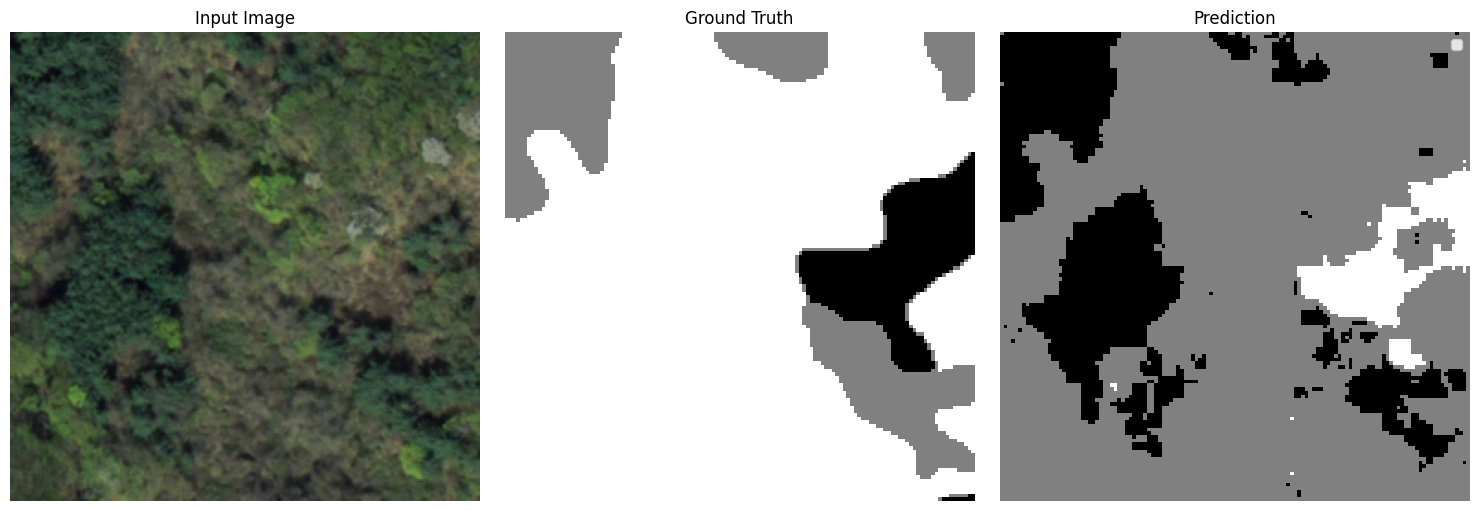

In [18]:
import torch
image = image_sh[0,:3,:,:].permute(1,2,0).numpy()
gt_image = gt[0,:,:,:].permute(1,2,0).squeeze(2).numpy()
# 예시로 carbon_pred를 사용합니다.
gt_pred_softmax = torch.softmax(gt_pred, dim=1)
_, predicted_labels = torch.max(gt_pred_softmax, dim=1)
gt_pred_image = predicted_labels.squeeze().detach().cpu().numpy()
cmap = 'gray'
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image)
ax[0].set_title('Input Image')
ax[0].axis('off')
ax[1].imshow(gt_image, cmap=cmap)
ax[1].set_title('Ground Truth')
ax[1].axis('off')
ax[2].imshow(gt_pred_image, cmap=cmap)
ax[2].set_title('Prediction')
ax[2].axis('off')
plt.legend()
plt.tight_layout()
plt.show()


(128, 128, 3)
(128, 128)


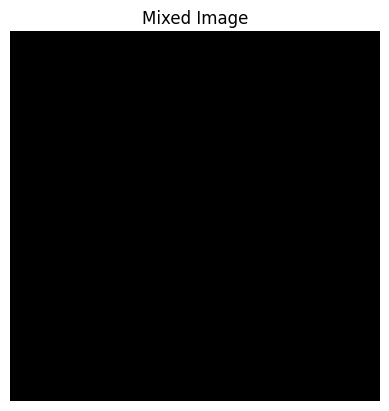

In [19]:
import torch
import  cv2
image = resizer(image_sh)
image = image[0,:3,:,:].permute(1,2,0).numpy()

print(image.shape)
gt_image = gt[0,:,:].permute(1,2,0).numpy()
# 예시로 carbon_pred를 사용합니다.
carbon_pred_softmax = torch.softmax(gt, dim=1)
_, predicted_labels = torch.max(carbon_pred_softmax, dim=1)
gt_pred_image = predicted_labels.squeeze().detach().cpu().numpy()
print(gt_pred_image.shape)
import matplotlib.pyplot as plt
import numpy as np

# 이미지와 세그멘테이션 맵을 섞기 위한 알파값
alpha = 0.2

# 예측된 세그멘테이션 맵을 색상으로 인코딩
segmentation_map = np.zeros_like(image, dtype=np.uint8)  # 세그멘테이션 맵을 0으로 초기화
segmentation_map[gt_pred_image == 0] = 0
segmentation_map[gt_pred_image == 1] = 64  # 클래스 1에 해당하는 픽셀을 흰색으로 설정
segmentation_map[gt_pred_image == 2] = 128
segmentation_map[gt_pred_image == 3] = 192

# 이미지와 세그멘테이션 맵을 섞음
mixed_image = cv2.addWeighted(image.astype(np.uint8), 1-alpha, segmentation_map, alpha, 0)

# 결과 시각화
plt.imshow(mixed_image)
plt.title('Mixed Image')
plt.axis('off')
plt.show()

# 탄소 저장량 시각화

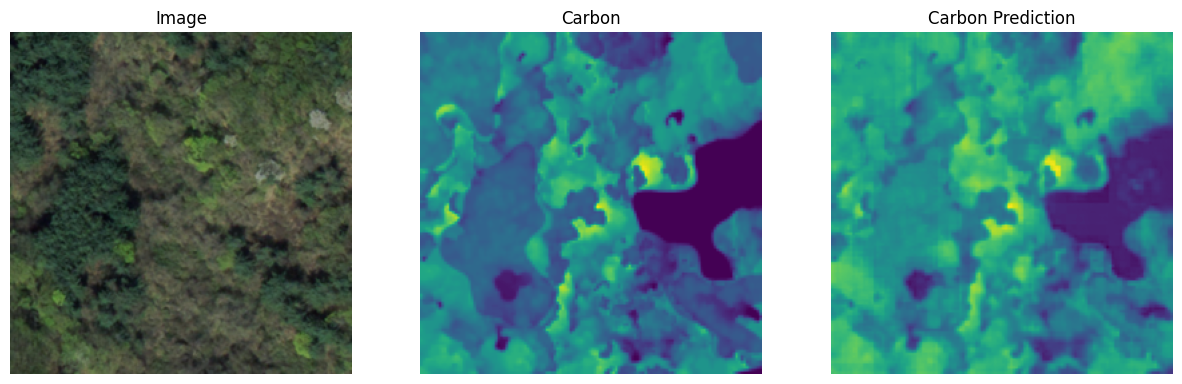

In [19]:
image = image_sh[0,:3,:,:].permute(1,2,0).numpy()
carbon_im = carbon[0].permute(1,2,0).detach().numpy()
carbon_pred_im = carbon_pred[0].permute(1,2,0).detach().numpy()

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image)
ax[0].set_title('Image')
ax[0].axis('off')
ax[1].imshow(carbon_im)
ax[1].set_title('Carbon')
ax[1].axis('off')
ax[2].imshow(carbon_pred_im)
ax[2].set_title('Carbon Prediction')
ax[2].axis('off')
plt.show()

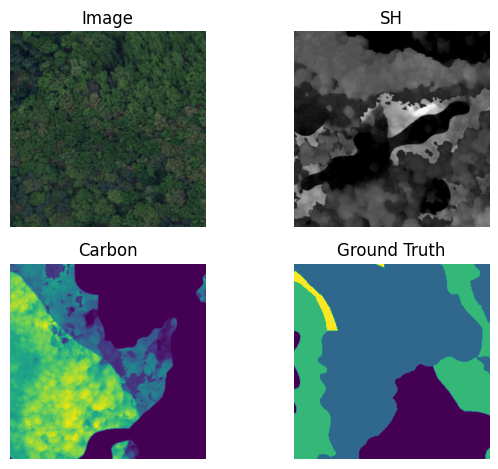

In [ ]:
image = image_sh[0,:3,:,:].permute(1,2,0).numpy()
sh = image_sh[0, 3:4, :, :].permute(1, 2, 0).numpy()
carbon_im = carbon[0].permute(1,2,0).numpy()
gt_im= gt[0].permute(1,2,0).numpy()

# Create a figure and subplots
fig, axs = plt.subplots(2, 2)

# Visualize the first image
axs[0, 0].imshow(image)
axs[0, 0].set_title('Image')
axs[0, 0].axis('off')

# Visualize the second image
axs[0, 1].imshow(sh, cmap='gray')
axs[0, 1].set_title('SH')
axs[0, 1].axis('off')

# Visualize the third image
axs[1, 0].imshow(carbon_im)
axs[1, 0].set_title('Carbon')
axs[1, 0].axis('off')

# Visualize the fourth image
axs[1, 1].imshow(gt_im)
axs[1, 1].set_title('Ground Truth')
axs[1, 1].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
